In [19]:
# import numba as nb
import numpy as np
import pandas as pd
import scipy.stats as stats
import chaospy as cp
from pathlib import Path
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from econsa.morris import (
    _shift_cov,
    _shift_sample,
    _uniform_to_standard_normal,
    elementary_effects,
)

# Replicating: [Introducing Copula in Monte Carlo Simulation](https://towardsdatascience.com/introducing-copula-in-monte-carlo-simulation-9ed1fe9f905)

## Random Variable Transformation

In [26]:
# Generate Monte Carlo sample

x = stats.uniform(0, 1).rvs(10000)

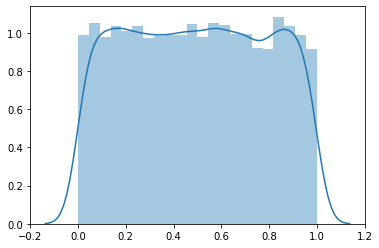

In [27]:
plt.clf()
sns.distplot(x)

In [28]:
norm = stats.distributions.norm()
x_trans = norm.ppf(x)

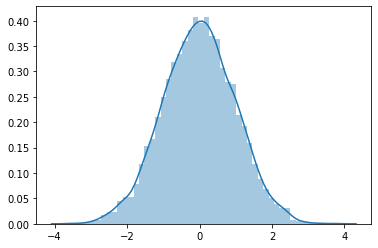

In [29]:
plt.clf()
sns.distplot(x_trans)

<Figure size 432x288 with 0 Axes>

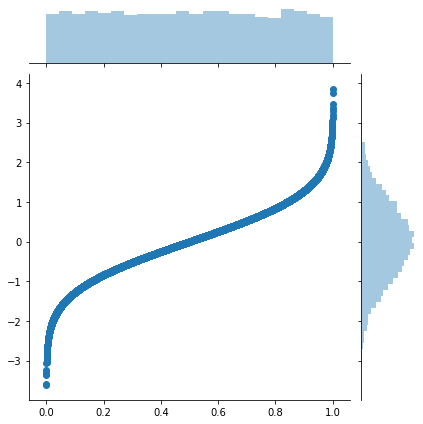

In [30]:
plt.clf()
sns.jointplot(x=x, y=x_trans)

## Gaussian Copula — Adding Variable Correlations

In [54]:
mvnorm = stats.multivariate_normal([0, 0], [[1., 0.5], [0.5, 1.]])
x = mvnorm.rvs((10000,))

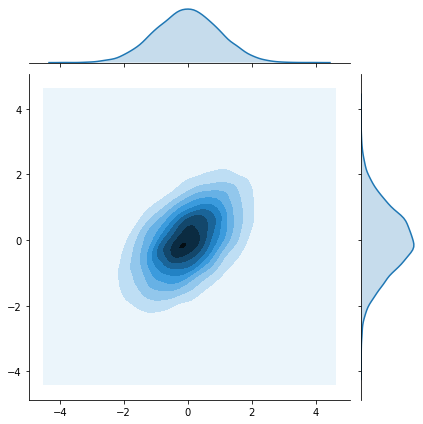

In [63]:
sns.jointplot(x=x[:,0], y=x[:,1], kind="kde")

In [64]:
norm = stats.norm([0],[1])
x_unif = norm.cdf(x)

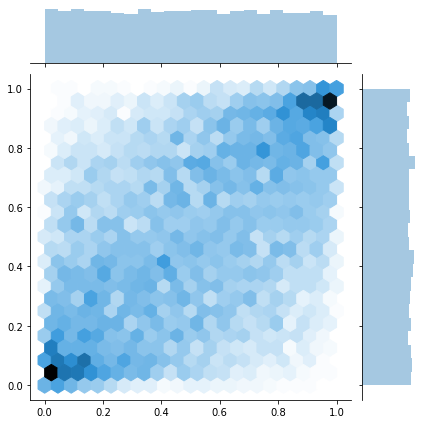

In [65]:
plt.clf()
sns.jointplot(x=x_unif[:,0], y=x_unif[:,1], kind="hex")

In [66]:
x1_tri  = stats.triang.ppf(x_unif[:, 0],  c=0.158 , loc=36, scale=21)
x2_norm =stats.norm(525, 112).ppf(x_unif[:, 1])

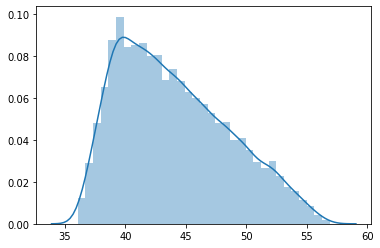

In [67]:
plt.clf()
sns.distplot(x1_tri)

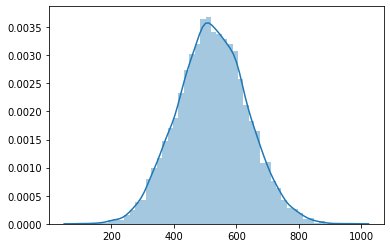

In [68]:
plt.clf()
sns.distplot(x2_norm)

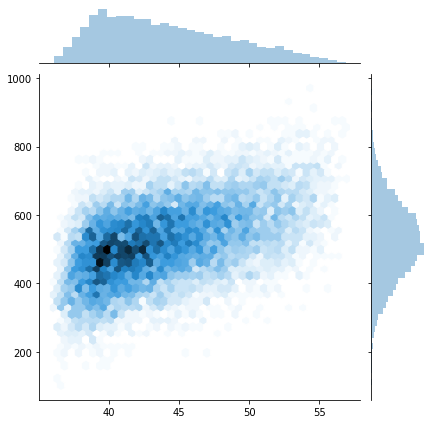

In [70]:
plt.clf()
sns.jointplot(x=x1_tri, y=x2_norm, kind="hex")

## Probabilistic Estimation of HCIIP

### No Variable Correlation Case

In [71]:
# HCIIP = GRV*NTG*POR*SHC/FVF

means = [0.]*5
cov = [[1., 0., 0., 0., 0.],
[0., 1., 0., 0., 0.],
[0., 0., 1., 0., 0.],
[0., 0., 0., 1., 0.],
[0., 0., 0., 0., 1.]]

mvnorm_std = stats.multivariate_normal(means,cov)
x = mvnorm_std.rvs(10000,random_state=42)
norm_std = stats.norm()
x_unif = norm_std.cdf(x)

#create individual distr.
grv = stats.triang(c=0.1 , loc=10000, scale=300).ppf(x_unif[:, 0])
ntg = stats.triang(c=0.2 , loc=0.5, scale=0.5).ppf(x_unif[:, 1])
phi = stats.truncnorm(-2*1.96,1.96,0.2,0.05).ppf(x_unif[:, 2])
shc = stats.norm(0.6,0.05).ppf(x_unif[:, 3])
fvf= stats.truncnorm(-1.96,2*1.96,1.3,0.1).ppf(x_unif[:, 4])

stoiip = 7758*grv*ntg*phi*shc/fvf/1e6

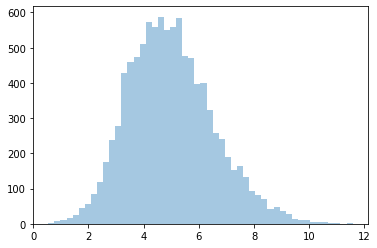

In [79]:
plt.clf()
sns.distplot(stoiip, kde=False)

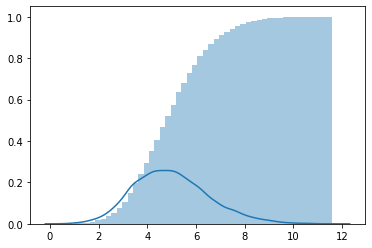

In [85]:
plt.clf()
sns.distplot(stoiip, hist_kws=dict(cumulative=True))

### Variable Correlation Case

In [86]:
means = [0.]*5

cov = [[1., 0., 0., 0., 0.],
[0., 1., 0.7, 0.6, 0.],
[0., 0.7, 1., 0.8, 0.],
[0., 0.6, 0.8, 1., 0.],
[0., 0., 0., 0., 1.]]

mvnorm_std = stats.multivariate_normal(means,cov)
x = mvnorm_std.rvs(10000,random_state=42)
norm_std = stats.norm()
x_unif = norm_std.cdf(x)

#create individual distr.
grv = stats.triang(c=0.1 , loc=10000, scale=300).ppf(x_unif[:, 0])
ntg = stats.triang(c=0.2 , loc=0.5, scale=0.5).ppf(x_unif[:, 1])
phi = stats.truncnorm(-2*1.96,1.96,0.2,0.05).ppf(x_unif[:, 2])
shc = stats.norm(0.6,0.05).ppf(x_unif[:, 3])
fvf= stats.truncnorm(-1.96,2*1.96,1.3,0.1).ppf(x_unif[:, 4])

stoiip = 7758*grv*ntg*phi*shc/fvf/1e6

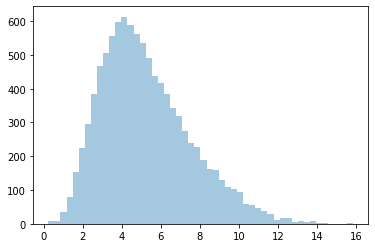

In [87]:
plt.clf()
sns.distplot(stoiip, kde=False)

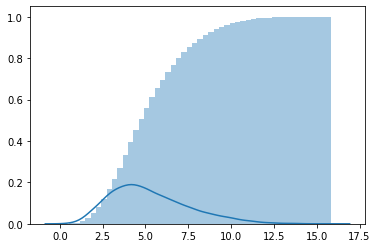

In [88]:
plt.clf()
sns.distplot(stoiip, hist_kws=dict(cumulative=True))

# Testing ChaosPy: [Distributions — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/distributions/index.html)

In [90]:
# to create a Gaussian random variable:
distribution = cp.Normal(mu=2, sigma=2)

In [91]:
# to create values from the probability density function:
t = np.linspace(-3, 3, 9)
distribution.pdf(t).round(3)

array([0.009, 0.021, 0.043, 0.078, 0.121, 0.164, 0.193, 0.198, 0.176])

In [93]:
# create values from the cumulative distribution function:
distribution.cdf(t).round(3)

array([0.006, 0.017, 0.04 , 0.085, 0.159, 0.266, 0.401, 0.55 , 0.691])

In [94]:
# To be able to perform any Monte Carlo method,
# each distribution contains random number generator:
distribution.sample(6).round(4)

array([3.1908, 1.5794, 2.1213, 0.3613, 2.2973, 2.5376])

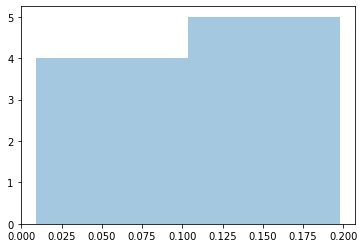

In [101]:
plt.clf()
sns.distplot(distribution.pdf(t).round(3), kde=False)

In [103]:
# to create low-discrepancy Hammersley sequences
# samples combined with antithetic variates:
distribution.sample(size=6, rule="halton", antithetic=True).round(4)

array([ 3.349 ,  0.651 , -0.3007,  4.3007,  2.6373,  1.3627])

## Moments: [Descriptive Statistics — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/descriptives.html#descriptives)

In [104]:
# the variance is defined as follows:
distribution.mom(2) - distribution.mom(1)**2

4.0

In [108]:
# or:
cp.Var(distribution)

array(4.)

## Seeding

In [112]:
np.random.seed(1234)
distribution.sample(5).round(4)

array([0.2554, 2.622 , 1.6865, 3.5808, 3.5442])

In [115]:
distribution.sample(5).round(4)

array([ 2.308 ,  2.0155, -2.4076,  3.4964,  4.3766])

## [Copulas — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/distributions/copulas.html)

In [134]:
np.random.seed(1234)
dist = cp.Iid(cp.Uniform(), 2)
copula = cp.Gumbel(dist, theta=1.5)

In [135]:
copula

Gumbel(Iid(Uniform(lower=0, upper=1), 2), theta=1.5)

In [136]:
np.random.seed(1234)
sample = copula.sample(10000)

<Figure size 432x288 with 0 Axes>

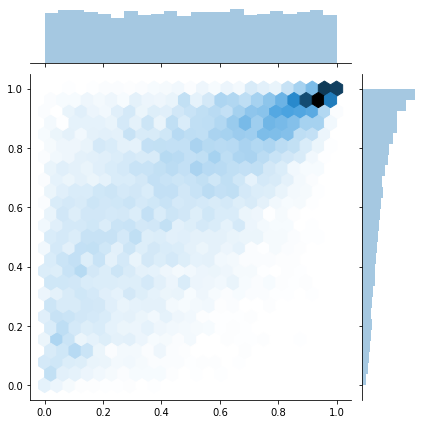

In [137]:
plt.clf()
sns.jointplot(x=sample[0], y=sample[1], kind="hex")

ok, what now…